# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

**1.1 Импортируем необходимые библиотеки.**

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


from sklearn.metrics import (mean_squared_error, r2_score)

import warnings
warnings.filterwarnings("ignore")

**1.2 Пользовательские функции.**

In [2]:
# Напишем функцию для первичной проверки данных

def check_data(data_df):
    print ('\033[1m' + 'Изучим исходные данные'+ '\033[0m')
    print(data_df.info())
    print(data_df.shape)
        
    missed_cells = data_df.isnull().sum().sum()/(data_df.shape[0]*(data_df.shape[1]-1))
    missed_rows = sum(data_df.isnull().sum(axis = 1)>0)/data_df.shape[0]
    print ('\033[1m' + '\nПроверка пропусков'+ '\033[0m')
    print ('Количество пропусков: {:.0f}'.format(data_df.isnull().sum().sum()))
    print ('Доля пропусков: {:.1%}'.format(missed_cells)+ '\033[0m')
    print ('Доля строк содержащих пропуски: {:.1%}'.format(missed_rows))

    ## Проверим дубликаты
    
    print ('\033[1m' + '\nПроверка на дубликаты'+ '\033[0m')
    print('Количество полных дубликатов: ', data_df.duplicated().sum())
        
    ## Посмотрим на сами данные
    
    print ('\033[1m' + '\nПервые пять строк датасета'+ '\033[0m')
    display(data_df.head())
    
    print('\033[1m' + '\nОписание количественных данных:'+ '\033[0m')
    display(data_df.describe().T)
     
    print('\033[1m' + '\nОписание категориальных данных:'+ '\033[0m')
    display(data_df.describe(include='object').T) 
    
    
    print('\033[1m' + '\nВывод уникальных значений по каждому категориаьному признаку:'+ '\033[0m')    
    df_object = data_df.select_dtypes(include='object').columns
    
    for i in df_object:
        print('\033[1m' + '_'+ str(i) + '\033[0m')
        display(data_df[i].value_counts())

**1.3 Загрузим данные.**

In [3]:
# 1й Регион

df_1 = pd.read_csv('/datasets/geo_data_0.csv')

In [4]:
df_1

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647
...,...,...,...,...,...
99995,DLsed,0.971957,0.370953,6.075346,110.744026
99996,QKivN,1.392429,-0.382606,1.273912,122.346843
99997,3rnvd,1.029585,0.018787,-1.348308,64.375443
99998,7kl59,0.998163,-0.528582,1.583869,74.040764


In [5]:
# 2й Регион

df_2 = pd.read_csv('/datasets/geo_data_1.csv')

In [6]:
df_2

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305
...,...,...,...,...,...
99995,QywKC,9.535637,-6.878139,1.998296,53.906522
99996,ptvty,-10.160631,-12.558096,5.005581,137.945408
99997,09gWa,-7.378891,-3.084104,4.998651,137.945408
99998,rqwUm,0.665714,-6.152593,1.000146,30.132364


In [7]:
# 3й Регион

df_3 = pd.read_csv('/datasets/geo_data_2.csv')

In [8]:
df_3

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746
...,...,...,...,...,...
99995,4GxBu,-1.777037,1.125220,6.263374,172.327046
99996,YKFjq,-1.261523,-0.894828,2.524545,138.748846
99997,tKPY3,-1.199934,-2.957637,5.219411,157.080080
99998,nmxp2,-2.419896,2.417221,-5.548444,51.795253


**1.4 Первичный осмотр данных.**

In [9]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ 
# 1й регион

check_data(df_1)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
(100000, 5)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.500419,0.871832,-1.408605,-0.072580,0.502360,1.073581,2.362331
f1,100000.0,0.250143,0.504433,-0.848218,-0.200881,0.250252,0.700646,1.343769
f2,100000.0,2.502647,3.248248,-12.088328,0.287748,2.515969,4.715088,16.003790
product,100000.0,92.500000,44.288691,0.000000,56.497507,91.849972,128.564089,185.364347



Описание категориальных данных:


,count,unique,top,freq
id,100000,99990,Tdehs,2



Вывод уникальных значений по каждому категориаьному признаку:
_id


Tdehs    2
QcMuo    2
fiKDv    2
bxg6G    2
bsk9y    2
        ..
SUmpj    1
RPCH2    1
6KUnI    1
7t5MZ    1
JGcgq    1
Name: id, Length: 99990, dtype: int64

In [10]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ 
# 2й регион

check_data(df_2)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
(100000, 5)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,1.141296,8.965932,-31.609576,-6.298551,1.153055,8.621015,29.421755
f1,100000.0,-4.796579,5.119872,-26.358598,-8.267985,-4.813172,-1.332816,18.734063
f2,100000.0,2.494541,1.703572,-0.018144,1.000021,2.011479,3.999904,5.019721
product,100000.0,68.825000,45.944423,0.000000,26.953261,57.085625,107.813044,137.945408



Описание категориальных данных:


,count,unique,top,freq
id,100000,99996,bfPNe,2



Вывод уникальных значений по каждому категориаьному признаку:
_id


bfPNe    2
LHZR0    2
wt4Uk    2
5ltQ6    2
pXWLm    1
        ..
lMnId    1
eaw2F    1
oq19F    1
bdWBS    1
MYZrD    1
Name: id, Length: 99996, dtype: int64

In [11]:
# ОПИСАТЕЛЬНЫЙ АНАЛИЗ 
# 3й регион

check_data(df_3)

Изучим исходные данные
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
(100000, 5)

Проверка пропусков
Количество пропусков: 0
Доля пропусков: 0.0%
Доля строк содержащих пропуски: 0.0%

Проверка на дубликаты
Количество полных дубликатов:  0

Первые пять строк датасета


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746



Описание количественных данных:


,count,mean,std,min,25%,50%,75%,max
f0,100000.0,0.002023,1.732045,-8.760004,-1.162288,0.009424,1.158535,7.238262
f1,100000.0,-0.002081,1.730417,-7.084020,-1.174820,-0.009482,1.163678,7.844801
f2,100000.0,2.495128,3.473445,-11.970335,0.130359,2.484236,4.858794,16.739402
product,100000.0,95.000000,44.749921,0.000000,59.450441,94.925613,130.595027,190.029838



Описание категориальных данных:


,count,unique,top,freq
id,100000,99996,xCHr8,2



Вывод уникальных значений по каждому категориаьному признаку:
_id


xCHr8    2
KUPhW    2
Vcm5J    2
VF7Jo    2
25VAR    1
        ..
ljSic    1
yDPzD    1
goqxn    1
j1Z9n    1
BRH7F    1
Name: id, Length: 99996, dtype: int64

In [12]:
# Удалим столбец 'id', т.к. он не влияют на качество обучения.

df_1 = df_1.drop(columns=['id'])
df_2 = df_2.drop(columns=['id'])
df_3 = df_3.drop(columns=['id'])


In [13]:
# Проверим

print(df_1.head(1))
print(df_2.head(1))
print(df_3.head(1))

         f0        f1       f2     product
0  0.705745 -0.497823  1.22117  105.280062
          f0     f1        f2   product
0 -15.001348 -8.276 -0.005876  3.179103
         f0        f1        f2    product
0 -1.146987  0.963328 -0.828965  27.758673


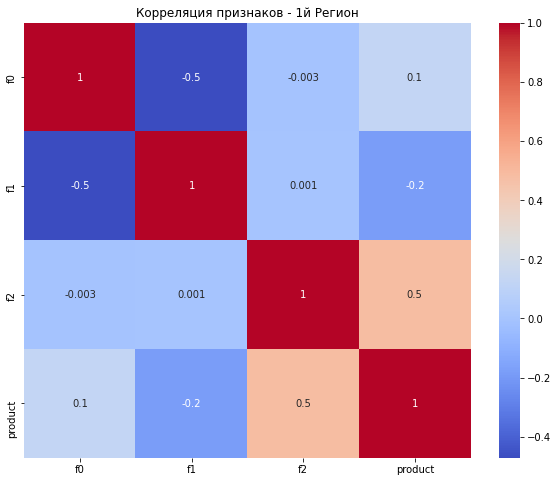

In [14]:
# Проверим на мультиколлинеарность 
# 1й Регион

plt.figure(figsize=(10, 8))
plt.title('Корреляция признаков - 1й Регион')
sns.heatmap(df_1.corr(method='spearman'), annot = True, cmap="coolwarm", annot_kws={'size':10}, fmt='.1g')
plt.show()

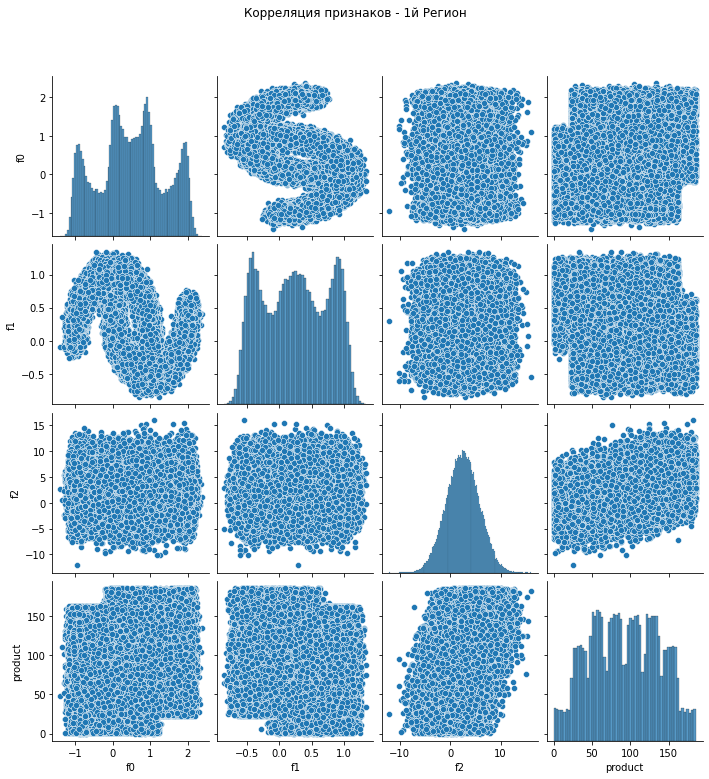

In [15]:
# Посмотрим графически

g_1 = sns.pairplot(df_1)
g_1.fig.suptitle('Корреляция признаков - 1й Регион',  y=1.08)
plt.show()

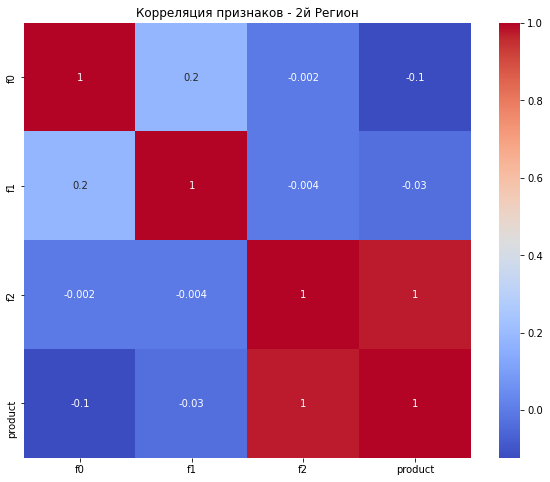

In [16]:
# Проверим на мультиколлинеарность 
# 2й Регион

plt.figure(figsize=(10, 8))
plt.title('Корреляция признаков - 2й Регион')
sns.heatmap(df_2.corr(method='spearman'), annot = True, cmap="coolwarm", annot_kws={'size':10}, fmt='.1g')
plt.show()

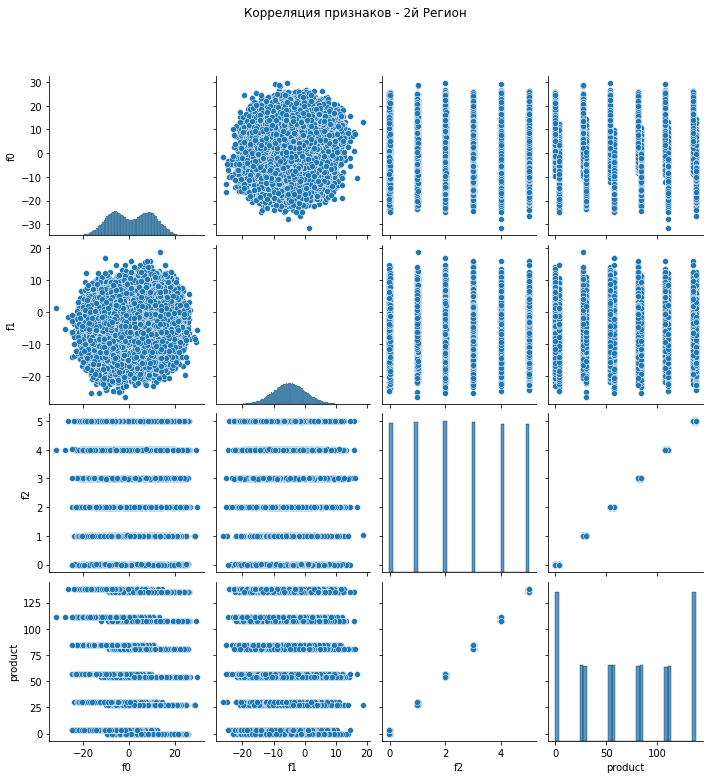

In [17]:
# Посмотрим графически

g_2 = sns.pairplot(df_2)
g_2.fig.suptitle('Корреляция признаков - 2й Регион',  y=1.08)
plt.show()

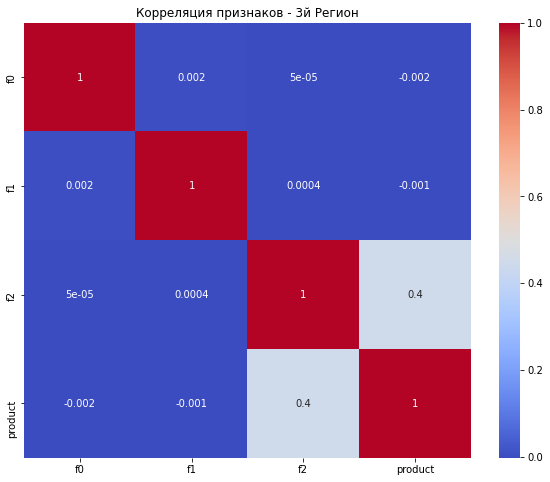

In [18]:
# Проверим на мультиколлинеарность 
# 3й Регион

plt.figure(figsize=(10, 8))
plt.title('Корреляция признаков - 3й Регион')
sns.heatmap(df_3.corr(method='spearman'), annot = True, cmap="coolwarm", annot_kws={'size':10}, fmt='.1g')
plt.show()

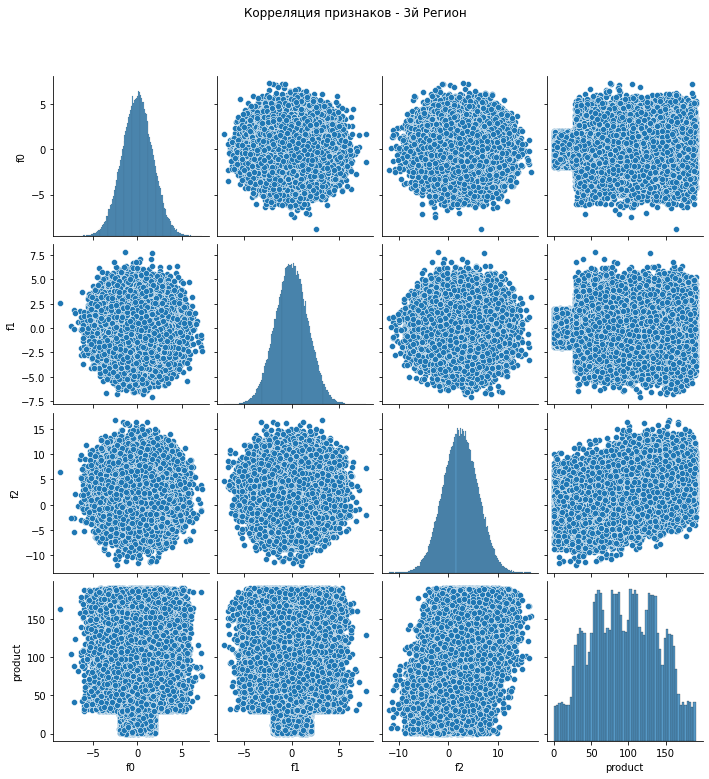

In [19]:
# Посмотрим графически

g_3 = sns.pairplot(df_3)
g_3.fig.suptitle('Корреляция признаков - 3й Регион',  y=1.08)
plt.show()

**Вывод:**
- у нас три таблицы по 100000 строк и 5 столбцов;
- пропусков нет;
- дубликаты не выявлены;
- наблюдаем высокую зависимость признака f2 от объема запасов в скважине для второго региона (линейная зависимость), такая зависмость можеть дать нам высокие баллы предсказаний для нашей модели;
- для 1 и 3 регионов зависимость также присутствует, но она ниже 0.6 и не должна оказать влияние.

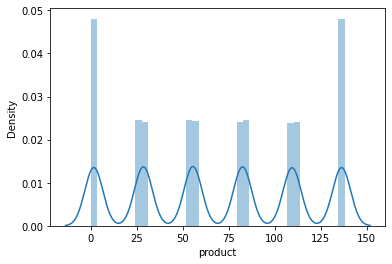

In [20]:
sns.distplot(df_2['product'], label=0)
plt.show()

## Обучение и проверка модели

**2.1. Формирование выборок и отбор признаков.**

**1й регион.**

In [21]:
# Разделим на признаки и целевой признак

target_1 = df_1['product']
features_1 = df_1.drop(['product'], axis=1)

In [22]:
# Сформируем 2 выборки: обучающую (75%) и валидационную (25%) 

features_train_1, features_valid_1, target_train_1, target_valid_1 = train_test_split(
    features_1, target_1, test_size=0.25, random_state=12345)

In [23]:
print(features_train_1.shape)
print(features_valid_1.shape)

(75000, 3)
(25000, 3)


**2й регион.**

In [24]:
# Разделим на признаки и целевой признак

target_2 = df_2['product']
features_2 = df_2.drop(['product'], axis=1)

In [25]:
# Сформируем 2 выборки: обучающую (75%) и валидационную (25%) 

features_train_2, features_valid_2, target_train_2, target_valid_2 = train_test_split(
    features_2, target_2, test_size=0.25, random_state=12345)

In [26]:
print(features_train_2.shape)
print(features_valid_2.shape)

(75000, 3)
(25000, 3)


**3й регион.**

In [27]:
# Разделим на признаки и целевой признак

target_3 = df_3['product']
features_3 = df_3.drop(['product'], axis=1)

In [28]:
# Сформируем 2 выборки: обучающую (75%) и валидационную (25%) 

features_train_3, features_valid_3, target_train_3, target_valid_3 = train_test_split(
    features_3, target_3, test_size=0.25, random_state=12345)

In [29]:
print(features_train_3.shape)
print(features_valid_3.shape)

(75000, 3)
(25000, 3)


**2.2 Обучим модель и сделаем предсказания на валидационной выборке.**

**1й регион.**

In [30]:
model_1 = LinearRegression()
model_1.fit(features_train_1, target_train_1)
predicted_1 = model_1.predict(features_valid_1)
mse_1 = mean_squared_error(target_valid_1, predicted_1)
rmse_1 = mse_1**0.5
print('Средний запас предсказанного сырья:', predicted_1.mean())
print('RMSE модели:', rmse_1)


Средний запас предсказанного сырья: 92.59256778438035
RMSE модели: 37.5794217150813


**2й регион.**

In [31]:
model_2 = LinearRegression()
model_2.fit(features_train_2, target_train_2)
predicted_2 = model_2.predict(features_valid_2)
mse_2 = mean_squared_error(target_valid_2, predicted_2)
rmse_2 = mse_2**0.5
print('Средний запас предсказанного сырья:', predicted_2.mean())
print('RMSE модели:', rmse_2)

Средний запас предсказанного сырья: 68.728546895446
RMSE модели: 0.893099286775617


**3й регион.**

In [32]:
model_3 = LinearRegression()
model_3.fit(features_train_3, target_train_3)
predicted_3 = model_3.predict(features_valid_3)
mse_3 = mean_squared_error(target_valid_3, predicted_3)
rmse_3 = mse_3**0.5
print('Средний запас предсказанного сырья:', predicted_3.mean())
print('RMSE модели:', rmse_3)

Средний запас предсказанного сырья: 94.96504596800489
RMSE модели: 40.02970873393434


**Вывод:**
- Из-за высокой зависимости признака f2 от объема запасов в скважине для второго региона мы получили результат: \
    **RMSE: 0.893099286775617** \
    **Средний запас предсказанного сырья: 68.728546895446**
    
    
- Для первого региона: \
    **RMSE модели: 37.5794217150813** \
    **Средний запас предсказанного сырья: 92.59256778438035** 
    
    
- Для третьего региона: \
    **RMSE модели: 40.02970873393434** \
    **Средний запас предсказанного сырья: 94.96504596800489**
    
    
- В первом и третьем регионе у моделей высокая погрешность.


## Подготовка к расчёту прибыли

**3.1 Все ключевые значения для расчётов сохраним в отдельных переменных**

In [33]:
POINTS = 500 # количество исследуемых точек
BEST_POINTS = 200 # лучшие точки для разработки
BUDGET = 10e9 # бюджет на разработку скважин в регионе 
ONE_BARREL_INCOME = 450 # цена за один баррель сырья 
REVENUE_PER_UNIT = 450_000 # доход с каждой единицы продукта
PROBABILITY_OF_LOSSES = 0.025 # вероятность убытков

**3.2 Рассчитаем достаточный объём сырья для безубыточной разработки новой скважины.**

In [34]:
sufficient_volume = BUDGET / (REVENUE_PER_UNIT * BEST_POINTS)
print('Достаточный объём сырья для безубыточной разработки новой скважины:', sufficient_volume)

Достаточный объём сырья для безубыточной разработки новой скважины: 111.11111111111111


**3.3 Сравним полученный объём сырья со средним запасом в каждом регионе.**

In [35]:
# 1й регион

average_stock_1 = round(df_1['product'].mean(), 2)
print('Средний запас в регионе №1:', average_stock_1)
print('Средний запас меньше достаточного объёма на:', sufficient_volume - average_stock_1)

Средний запас в регионе №1: 92.5
Средний запас меньше достаточного объёма на: 18.611111111111114


In [36]:
# 2й регион

average_stock_2 = round(df_2['product'].mean(), 2)
print('Средний запас в регионе №2:', average_stock_2)
print('Средний запас меньше достаточного объёма на:', sufficient_volume - average_stock_2)

Средний запас в регионе №2: 68.83
Средний запас меньше достаточного объёма на: 42.281111111111116


In [37]:
# 3й регион

average_stock_3 = round(df_3['product'].mean(), 3)
print('Средний запас в регионе №3:', average_stock_3)
print('Средний запас меньше достаточного объёма на:', sufficient_volume - average_stock_3)

Средний запас в регионе №3: 95.0
Средний запас меньше достаточного объёма на: 16.111111111111114


**Вывод:**
- достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей;
- средний запас в регионах 68-95 тыс. баррелей, что меньше достаточного объема на 16-42 тыс. баррелей;
- ближе всего для безубыточной разработки запас в регионе №3.

Исходя из полученных данных мы видим, что среднее значение запасов в регионах меньше, чем необходимо для безубыточной разработки. Регионы убыточны и нам надо выбрать скважины с максимальными запасами.

## Расчёт прибыли и рисков 

**4.1 Напишеми функцию для расчёта прибыли по выбранным скважинам и предсказаниям модели:**
- выберем скважины с максимальными значениями предсказаний;
- просуммируем целевое значение объёма сырья, соответствующее этим предсказаниям;
- рассчитаем прибыль для полученного объёма сырья.

In [38]:
def revenue(target, probabilities, count):
    probs_sorted = pd.Series(probabilities, index=target.index).sort_values(ascending=False)
    selected = target[probs_sorted.index][:count]
    rev = (selected.sum() * REVENUE_PER_UNIT - BUDGET) / 10e6
    return rev

In [39]:
print('Прибыль в регионе №1:', round(revenue(target_valid_1, predicted_1, 200), 2), 'млн. рублей')
print('Прибыль в регионе №2:', round(revenue(target_valid_2, predicted_2, 200), 2), 'млн. рублей')
print('Прибыль в регионе №3:', round(revenue(target_valid_3, predicted_3, 200), 2), 'млн. рублей')

Прибыль в регионе №1: 332.08 млн. рублей
Прибыль в регионе №2: 241.51 млн. рублей
Прибыль в регионе №3: 271.03 млн. рублей


**Самый прибыльный регион - №1.** 

**4.2 Посчитаем риски и прибыль для каждого региона:**
- применим технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
- найдем среднюю прибыль, 95%-й доверительный интервал и риск убытков.

In [44]:
def bootstrap(target, probabilities):
    state = np.random.RandomState(12345)
    values = []
    count=0
        
    for i in range(1000):
        target_subsample = pd.Series(target).reset_index(drop=True).sample(n=500, random_state=state,replace=True)
        probs_subsample = pd.Series(probabilities)[target_subsample.index] 
        values.append(revenue(target_subsample, probs_subsample, 200)) 
                
    values = pd.Series(values)
    lower = values.quantile(0.025) 
    upper = values.quantile(0.975) 
    mean = values.mean() 
    risk = (values < 0).mean() * 100
    
    plt.title('Распределение прибыли')
    values.hist(figsize=(9,6))
    plt.show()
            
    print(f'Средняя прибыль = {mean:.0f} млн. рублей.')
    print(f'95%-й доверительный интервал: {lower:.0f} - {upper:.0f} млн. рублей.')    
    print(f'Риск убытка = {risk}%')    

**1й регион.**

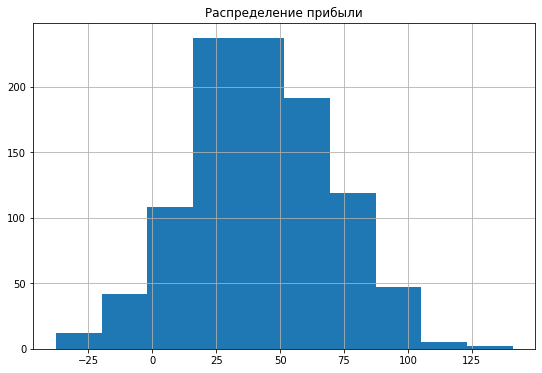

Средняя прибыль = 43 млн. рублей.
95%-й доверительный интервал: -10 - 95 млн. рублей.
Риск убытка = 6.0%


In [46]:
bootstrap(target_valid_1,predicted_1)

**2й регион.**

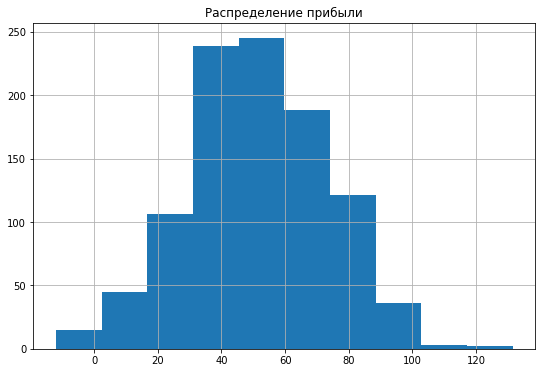

Средняя прибыль = 52 млн. рублей.
95%-й доверительный интервал: 7 - 93 млн. рублей.
Риск убытка = 1.0%


In [47]:
bootstrap(target_valid_2,predicted_2)

**3й регион.**

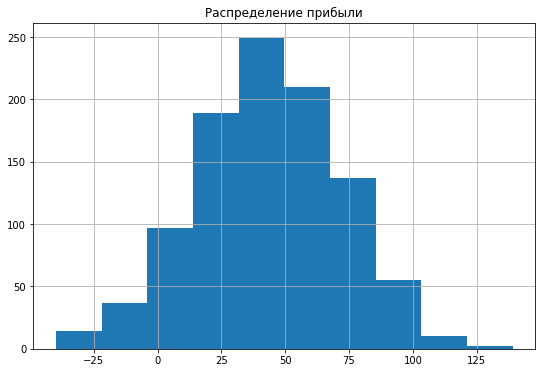

Средняя прибыль = 44 млн. рублей.
95%-й доверительный интервал: -13 - 97 млн. рублей.
Риск убытка = 6.4%


In [48]:
bootstrap(target_valid_3,predicted_3)

**Вывод:** 


**Для региона №1:**
- Средняя прибыль = 43 млн. рублей.
- 95%-й доверительный интервал: -10 - 95 млн. рублей.
- Риск убытка = 6.0%

**Для региона №2:**
- Средняя прибыль = 52 млн. рублей.
- 95%-й доверительный интервал: 7 - 93 млн. рублей.
- Риск убытка = 1.0%

**Для региона №3:**
- Средняя прибыль = 44 млн. рублей.
- 95%-й доверительный интервал: -13 - 97 млн. рублей.
- Риск убытка = 6.4%

Наименьший риск убытка и наибольшая прибыль в регионе №2, но наибольшая прибыль по предсказанию модели будет в регионе №1.

Наиболее подходящим для разработки будет регион №2, т.к. в нём минимальные риски и потенциально высокие показатели средней прибыли.

**Общий вывод:**
1. **_Были подготовлены данные:_**
- у нас три таблицы по 100000 строк и 5 столбцов;
- пропусков нет;
- дубликаты не выявлены;
- наблюдаем высокую зависимость признака f2 от объема запасов в скважине для второго региона (линейная зависимость), такая зависмость можеть дать нам высокие баллы предсказаний для нашей модели;
- для 1 и 3 регионов зависимость также присутствует, но она ниже 0.6 и не должна оказать влияние.

2. **_Обучена и проверена модель для каждого региона:_**
- данные разбиты на обучающую и валидационную выборки в соотношении 75:25;
- обучена модель и сделаны предсказания на валидационной выборке;
- сохранены предсказания и правильные ответы на валидационной выборке;
- напечатаны на экране средний запас предсказанного сырья и RMSE модели;

- из-за высокой зависимости признака f2 от объема запасов в скважине для второго региона мы получили результат: \
    **RMSE: 0.893099286775617** \
    **Средний запас предсказанного сырья: 68.728546895446**
    
    
- Для первого региона: \
    **RMSE модели: 37.5794217150813** \
    **Средний запас предсказанного сырья: 92.59256778438035** 
    
    
- Для третьего региона: \
    **RMSE модели: 40.02970873393434** \
    **Средний запас предсказанного сырья: 94.96504596800489**
    
    
- В первом и третьем регионе у моделей высокая погрешность.

3. **_Произведена подготовка к расчёту прибыли:_**
- все ключевые значения для расчётов сохранены в отдельных переменных;
- рассчитан достаточный объём сырья для безубыточной разработки новой скважины;
- произведено сравнение полученного объёма сырья со средним запасом в каждом регионе;
- достаточный объём сырья для безубыточной разработки новой скважины: 111.11 тыс. баррелей;
- средний запас в регионах 68-95 тыс. баррелей, что меньше достаточного объема на 16-42 тыс. баррелей;
- ближе всего для безубыточной разработки запас в регионе №3.

4. **_Написана функция для расчёта прибыли по выбранным скважинам и предсказаниям модели_**
- выбраны скважины с максимальными значениями предсказаний;
- просуммировано целевое значение объёма сырья, соответствующее этим предсказаниям;
- рассчитана прибыль для полученного объёма сырья.
- прибыль в регионе №1: 332.08 млн. рублей - **_самый прибыльный регион_**
- прибыль в регионе №2: 241.51 млн. рублей
- прибыль в регионе №3: 271.03 млн. рублей

5. **_Посчитаны риски и прибыль для каждого региона:_**
- применена техника Bootstrap с 1000 выборок, чтобы найти распределение прибыли;
- найдена средняя прибыль, 95%-й доверительный интервал и риск убытков. Убыток — это отрицательная прибыль;

**Для региона №1:**
- Средняя прибыль = 43 млн. рублей.
- 95%-й доверительный интервал: -10 - 95 млн. рублей.
- Риск убытка = 6.0%

**Для региона №2:**
- Средняя прибыль = 52 млн. рублей.
- 95%-й доверительный интервал: 7 - 93 млн. рублей.
- Риск убытка = 1.0%

**Для региона №3:**
- Средняя прибыль = 44 млн. рублей.
- 95%-й доверительный интервал: -13 - 97 млн. рублей.
- Риск убытка = 6.4%

Наименьший риск убытка и наибольшая прибыль в регионе №2, но наибольшая прибыль по предсказанию модели будет в регионе №1.

**Наиболее подходящим для разработки будет регион №2, т.к. в нём минимальные риски и потенциально высокие показатели средней прибыли.**






## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнен шаг 1: данные подготовлены
- [ ]  Выполнен шаг 2: модели обучены и проверены
    - [ ]  Данные корректно разбиты на обучающую и валидационную выборки
    - [ ]  Модели обучены, предсказания сделаны
    - [ ]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [ ]  На экране напечатаны результаты
    - [ ]  Сделаны выводы
- [ ]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [ ]  Для всех ключевых значений созданы константы Python
    - [ ]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [ ]  По предыдущему пункту сделаны выводы
    - [ ]  Написана функция расчёта прибыли
- [ ]  Выполнен шаг 4: посчитаны риски и прибыль
    - [ ]  Проведена процедура *Bootstrap*
    - [ ]  Все параметры бутстрепа соответствуют условию
    - [ ]  Найдены все нужные величины
    - [ ]  Предложен регион для разработки месторождения
    - [ ]  Выбор региона обоснован